In [2]:
import matplotlib.pyplot as plt
from datetime import datetime
import networkx as nx
from itertools import combinations
import numpy as np
from collections import defaultdict
from statsmodels.distributions.empirical_distribution import ECDF
import json
from scipy.stats import spearmanr
import pandas as pd
import seaborn as sns
import community.community_louvain as community_louvain

In [3]:
# Canali target da cui raccogliere i video
canali = [
    "Fanpage.it",
    "La Repubblica",
    "FABRIZIO CORONA",
    "Gianmarco Zagato",
    "La7 Attualità",
    "Rai",
    "Bugalalla Crime",
    "DarkSide - Storia Segreta d'Italia"
]

# Intervallo temporale per i video (due settimana prima dalla riapertura del caso fino ai giorni odierni)
begin_date = datetime(2025, 2, 25)
end_date = datetime(2025, 7, 14)

In [4]:
# Crea struttura Comment
class Comment:
    def __init__(self, id, video_id, content, author, date, likes, reply_to_id=None):
        self.id = id
        self.video_id = video_id
        self.content = content
        self.author = author
        self.date = date
        self.likes = int(likes)
        self.reply_to_id = reply_to_id

    def __repr__(self):
        return f"<Comment by {self.author} on {self.date.strftime('%Y-%m-%d')}>"


In [5]:
with open("./comments.json", "r", encoding="utf-8") as f:
    comments = json.load(f)

with open("./videos.json", "r", encoding="utf-8") as f:
    videos = json.load(f)

with open("./videos_with_views.json", "r", encoding="utf-8") as f:
    videos_with_views = json.load(f)

In [6]:
# Strutture dati utilizzabili per l'analisi
# Mappa video_id → canale
Channel_of = {v["video_id"]: v["channel"] for v in videos}

# Mappa canale → lista video_id
Videos_of = defaultdict(list)
for v in videos:
    Videos_of[v["channel"]].append(v["video_id"])

# Mappa video_id → data
Date_of_video = {v["video_id"]: v["published_at"] for v in videos}

# Mappa video_id → views
Video_to_views = {v["video_id"]: v["viewCount"] for v in videos_with_views}

# Mappa video_id → like
Video_to_likes = {v["video_id"]: v.get("likeCount", 0) for v in videos_with_views}

# Mappa video_id → titolo video
Video_to_title = {v["video_id"]: v.get("title", "Sconosciuto") for v in videos}

# Inizializza dizionari ausiliari
Commenters_of_video = defaultdict(set)
Videos_commented_by = defaultdict(set)
Channels_commented_by = defaultdict(set)
Commenters_of_channel = defaultdict(set)
Comments_of_channel = defaultdict(list)
Comments_by_user = defaultdict(list)

# Popola strutture dai commenti
for c in comments:
    video_id = c["video_id"]
    author = c["author"]
    channel = Channel_of.get(video_id, "Unknown")

    comment_obj = Comment(
        id=c["comment_id"],
        video_id=video_id,
        content=c["content"],
        author=author,
        date=c["date"],
        likes=c["likes"],
        reply_to_id=c.get("reply_to_id")
    )

    Commenters_of_video[video_id].add(author)
    Videos_commented_by[author].add(video_id)
    Channels_commented_by[author].add(channel)
    Commenters_of_channel[channel].add(author)
    Comments_of_channel[channel].append(comment_obj)
    Comments_by_user[author].append(comment_obj)

# Mappa comment_id → autore
author_of_comment = {}
for user_comments in Comments_by_user.values():
    for comment in user_comments:
        author_of_comment[comment.id] = comment.author

# Debug: stampa sommaria
print(f"Video totali: {len(Channel_of)}")
print(f"Utenti unici: {len(Comments_by_user)}")
print(f"Canali totali: {len(Videos_of)}")
print(f"Commenti totali: {len(comments)}")


Video totali: 352
Utenti unici: 31923
Canali totali: 8
Commenti totali: 181631


In [7]:
# Grafo utente-utente
utente_utente_G = nx.Graph()
edge_weights = defaultdict(int)

user_comment_count = {user: len(Comments_by_user[user]) for user in Comments_by_user}
active_users = {user for user, count in user_comment_count.items() if count >= 5}

for video_id, commenters in Commenters_of_video.items():
    commenters = [u for u in commenters if u in active_users]
    if len(commenters) < 2:
        continue
    for u1, u2 in combinations(commenters, 2):
        if u1 and u2:
            edge = tuple(sorted([u1, u2]))
            edge_weights[edge] += 1

for (u1, u2), weight in edge_weights.items():
    if weight >= 3:  
        utente_utente_G.add_edge(u1, u2, weight=weight)

for user in utente_utente_G.nodes:
    num_videos = len(Videos_commented_by.get(user, set()))
    utente_utente_G.nodes[user]["video_count"] = num_videos

In [8]:
nx.write_gexf(utente_utente_G, "rete_utente_utente.gexf")

In [9]:
isolati = [n for n in utente_utente_G.nodes if utente_utente_G.degree(n) == 0]
utente_utente_G.remove_nodes_from(isolati)

In [10]:
for user in utente_utente_G.nodes:
    utente_utente_G.nodes[user]['comment_count'] = len(Comments_by_user.get(user, []))
    utente_utente_G.nodes[user]['channels_commented'] = len(Channels_commented_by.get(user, set()))
    print(f"Utente: {user}, Video: {utente_utente_G.nodes[user]['video_count']}, Commenti: {utente_utente_G.nodes[user]['comment_count']}, Canali: {utente_utente_G.nodes[user]['channels_commented']}")

Utente: @PIPPIMARIA34, Video: 41, Commenti: 66, Canali: 5
Utente: @gamingserver303, Video: 17, Commenti: 20, Canali: 4
Utente: @Vittoria-y3q, Video: 14, Commenti: 15, Canali: 5
Utente: @samanthaientile1049, Video: 6, Commenti: 7, Canali: 3
Utente: @ZdenkaLisica, Video: 17, Commenti: 23, Canali: 5
Utente: @claudiarivolta542, Video: 18, Commenti: 24, Canali: 4
Utente: @varcorvio8474, Video: 23, Commenti: 47, Canali: 5
Utente: @Bianca.Castafiore, Video: 48, Commenti: 172, Canali: 5
Utente: @annalisadami4257, Video: 6, Commenti: 9, Canali: 4
Utente: @paololatini6476, Video: 13, Commenti: 14, Canali: 3
Utente: @latavernadeilettori, Video: 10, Commenti: 66, Canali: 5
Utente: @antonioirrera9641, Video: 78, Commenti: 123, Canali: 7
Utente: @salentino007, Video: 9, Commenti: 13, Canali: 5
Utente: @tizianamassaro73, Video: 26, Commenti: 36, Canali: 6
Utente: @annalucchese9541, Video: 18, Commenti: 29, Canali: 3
Utente: @krm-hj6yc, Video: 39, Commenti: 136, Canali: 4
Utente: @marina-t-27, Video: 

In [34]:
# Calcolo delle statistiche per il grafo utente-utente
num_nodi_utenti = utente_utente_G.number_of_nodes()
num_archi_utenti = utente_utente_G.number_of_edges()
print(f"\n=== Statistiche Generiche ===")
print(f"Numero di nodi (utenti): {num_nodi_utenti}")
print(f"Numero di archi: {num_archi_utenti}")

densita_utenti = nx.density(utente_utente_G)
print(f"Densità del grafo: {densita_utenti:.4f}")

gradi_utenti = [d for n, d in utente_utente_G.degree()]
print(f"Grado medio: {np.mean(gradi_utenti):.2f}")
print(f"Grado mediano: {np.median(gradi_utenti)}")
print(f"Grado minimo: {np.min(gradi_utenti)}")
print(f"Grado massimo: {np.max(gradi_utenti)}")


=== Statistiche Generiche ===
Numero di nodi (utenti): 6925
Numero di archi: 2799353
Densità del grafo: 0.1168
Grado medio: 808.48
Grado mediano: 431.0
Grado minimo: 1
Grado massimo: 6358


In [35]:
video_counts = [utente_utente_G.nodes[n].get('video_count', 0) for n in utente_utente_G.nodes]
print(f"\n=== Statistiche Numero Video Commentati per Utente ===")
print(f"Media: {np.mean(video_counts):.2f}")
print(f"Mediana: {np.median(video_counts):.0f}")
print(f"Deviazione standard: {np.std(video_counts):.2f}")
print(f"Min: {np.min(video_counts)}")
print(f"Max: {np.max(video_counts)}")

channel_counts = [utente_utente_G.nodes[n].get('channels_commented', 0) for n in utente_utente_G.nodes]
print(f"\n=== Statistiche Numero Canali Commentati per Utente ===")
print(f"Media: {np.mean(channel_counts):.2f}")
print(f"Mediana: {np.median(channel_counts):.0f}")
print(f"Deviazione standard: {np.std(channel_counts):.2f}")
print(f"Min: {np.min(channel_counts)}")
print(f"Max: {np.max(channel_counts)}")

utenti_grafo = set(utente_utente_G.nodes)
canale_to_n_utenti = {canale: len(Commenters_of_channel[canale] & utenti_grafo) for canale in canali}
df_classifica_canali = pd.DataFrame.from_dict(canale_to_n_utenti, orient='index', columns=['Utenti unici (grafo)'])
df_classifica_canali = df_classifica_canali.sort_values('Utenti unici (grafo)', ascending=False)
print("\n=== Classifica Canali più commentati ===")
print(df_classifica_canali)


=== Statistiche Numero Video Commentati per Utente ===
Media: 11.23
Mediana: 7
Deviazione standard: 10.92
Min: 3
Max: 171

=== Statistiche Numero Canali Commentati per Utente ===
Media: 2.56
Mediana: 2
Deviazione standard: 1.22
Min: 1
Max: 8

=== Classifica Canali più commentati ===
                                    Utenti unici (grafo)
Bugalalla Crime                                     6111
DarkSide - Storia Segreta d'Italia                  3840
Rai                                                 3679
FABRIZIO CORONA                                     2027
Fanpage.it                                          1231
La Repubblica                                        578
Gianmarco Zagato                                     182
La7 Attualità                                        111



=== Statistiche Similarità Jaccard ===
Media: 0.1329
Mediana: 0.1207
Deviazione standard: 0.0631
Min: 0.0166
Max: 1.0000


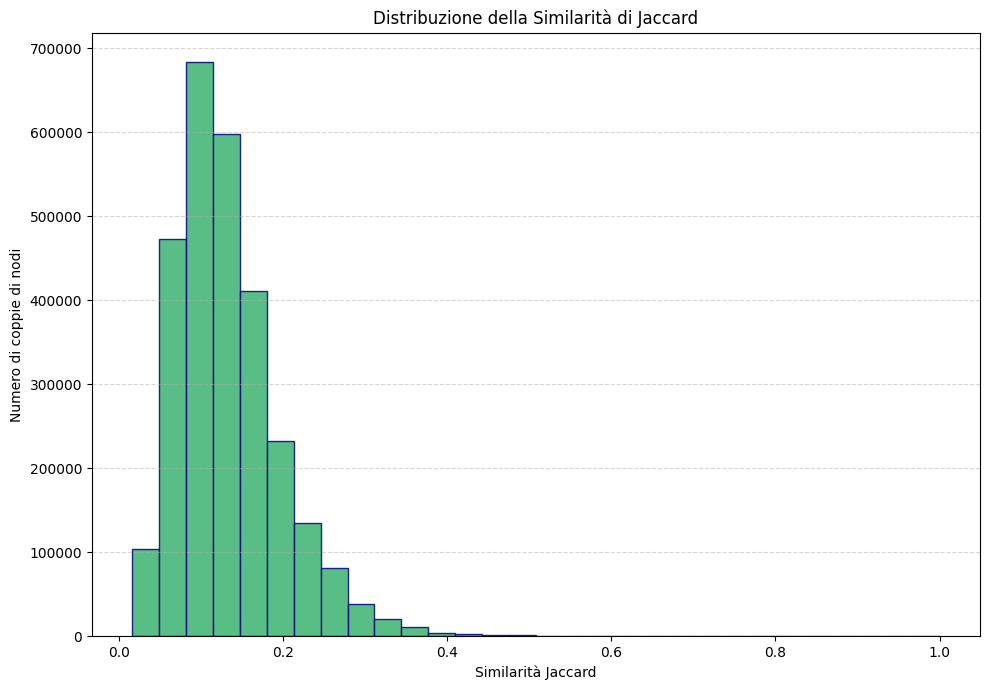

In [36]:
jaccard_similarities = []
for u, v in utente_utente_G.edges():
    set_u = Videos_commented_by.get(u, set())
    set_v = Videos_commented_by.get(v, set())
    intersection = len(set_u & set_v)
    union = len(set_u | set_v)
    jaccard = intersection / union if union > 0 else 0
    jaccard_similarities.append(jaccard)

print(f"\n=== Statistiche Similarità Jaccard ===")
if jaccard_similarities:
    print(f"Media: {np.mean(jaccard_similarities):.4f}")
    print(f"Mediana: {np.median(jaccard_similarities):.4f}")
    print(f"Deviazione standard: {np.std(jaccard_similarities):.4f}")
    print(f"Min: {np.min(jaccard_similarities):.4f}")
    print(f"Max: {np.max(jaccard_similarities):.4f}")
else:
    print("Nessuna similarità Jaccard calcolabile (nessun arco nel grafo).")

plt.figure(figsize=(10, 7))
plt.hist(jaccard_similarities, bins=30, color='mediumseagreen', edgecolor='navy', alpha=0.85)
plt.title("Distribuzione della Similarità di Jaccard")
plt.xlabel("Similarità Jaccard")
plt.ylabel("Numero di coppie di nodi")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [13]:
partition = community_louvain.best_partition(utente_utente_G)
modularity = community_louvain.modularity(partition, utente_utente_G)
print(f"\n=== Modularità della partizione ===")
print(f"Modularità: {modularity:.4f}")


=== Modularità della partizione ===
Modularità: 0.1190


In [14]:
# Strutture ausiliarie
community_to_users = defaultdict(set)
for user, comm in partition.items():
    community_to_users[comm].add(user)

community_to_channels = defaultdict(set)
for comm, users in community_to_users.items():
    for user in users:
        community_to_channels[comm].update(Channels_commented_by.get(user, set()))

In [15]:
utenti_multicanale_per_canale = {}
for canale in canali:
    utenti = Commenters_of_channel[canale]
    if utenti:
        multi = sum(1 for u in utenti if len(Channels_commented_by[u]) > 1)
        utenti_multicanale_per_canale[canale] = multi
    else:
        utenti_multicanale_per_canale[canale] = 0

community_of_user = {}
for comm, users in community_to_users.items():
    for u in users:
        community_of_user[u] = comm

N_MIN_REPLY = 2  
utenti_ponte = set()
community_collegate_da_utente = dict()
for user, commenti in Comments_by_user.items():
    comm_user = community_of_user.get(user)
    if comm_user is None:
        continue

    altre_community = set()
    for c in commenti:
        reply_to = c.reply_to_id
        if reply_to and reply_to in author_of_comment:
            replied_user = author_of_comment[reply_to]
            comm_replied = community_of_user.get(replied_user)
            if comm_replied is not None and comm_replied != comm_user:
                altre_community.add(comm_replied)
    if len(altre_community) >= N_MIN_REPLY:
        utenti_ponte.add(user)
        community_collegate_da_utente[user] = altre_community

In [16]:
for u, comms in community_collegate_da_utente.items():
    print(f"Utente {u} collega le community: {comms}")

Utente @mariaantoniettafloris4096 collega le community: {1, 2}
Utente @principessavolante collega le community: {0, 2}
Utente @elisabettaparravicini2631 collega le community: {0, 2}
Utente @AuroraModica-u6e collega le community: {0, 1}
Utente @odissea8370 collega le community: {1, 2}
Utente @Riccardo6994 collega le community: {1, 2}
Utente @annaebasta1329 collega le community: {1, 2}
Utente @claudiarivolta542 collega le community: {0, 2}
Utente @Mr78frank collega le community: {1, 2}
Utente @krm-hj6yc collega le community: {0, 1}
Utente @monicaelle3634 collega le community: {1, 2}
Utente @varcorvio8474 collega le community: {0, 2}
Utente @Serpentina54 collega le community: {1, 2}
Utente @lourdes4182 collega le community: {1, 2}
Utente @tizianamassaro73 collega le community: {0, 2}
Utente @AngelaDeangelis-kv7nb collega le community: {1, 2}
Utente @gianbagheera15 collega le community: {0, 2}
Utente @pieravigano8152 collega le community: {1, 2}
Utente @So.phia3341 collega le community: {1

In [17]:
for comm in sorted(community_to_users):
    users = community_to_users[comm]
    channels = community_to_channels[comm]
    n_users = len(users)
    n_channels = len(channels)
    n_multi = sum(1 for u in users if len(Channels_commented_by.get(u, set())) > 1)
    n_ponte = sum(
        1 for u in users
        if u in utenti_ponte
    )
    print(f"\nCommunity {comm}:")
    print(f"  Utenti: {n_users}")
    print(f"  Canali commentati: {n_channels}")
    print(f"  Utenti multicanale: {n_multi}")
    print(f"  Utenti ponte: {n_ponte}")


Community 0:
  Utenti: 2615
  Canali commentati: 8
  Utenti multicanale: 2437
  Utenti ponte: 516

Community 1:
  Utenti: 2175
  Canali commentati: 8
  Utenti multicanale: 1526
  Utenti ponte: 436

Community 2:
  Utenti: 2135
  Canali commentati: 8
  Utenti multicanale: 1556
  Utenti ponte: 469


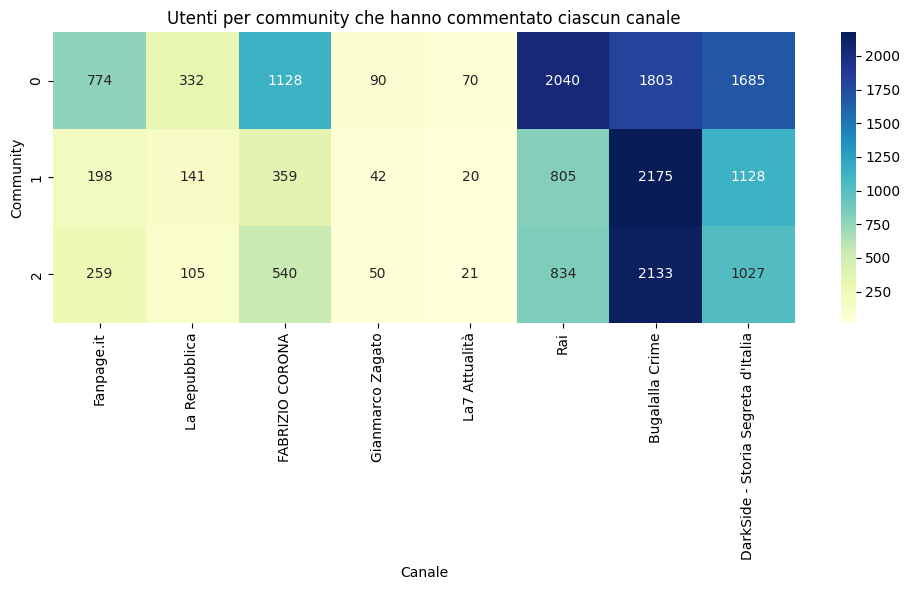

In [18]:
mat_comm_canale = pd.DataFrame(
    0, index=sorted(community_to_users.keys()), columns=canali
)

for comm, users in community_to_users.items():
    for user in users:
        for ch in Channels_commented_by.get(user, []):
            if ch in canali:
                mat_comm_canale.loc[comm, ch] += 1


plt.figure(figsize=(10, 6))
sns.heatmap(mat_comm_canale, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Utenti per community che hanno commentato ciascun canale")
plt.xlabel("Canale")
plt.ylabel("Community")
plt.tight_layout()
plt.show()

In [39]:
pd.options.display.float_format = '{:,.0f}'.format

utenti_ponte_per_canale = {}
utenti_totali_per_canale = {}
utenti_grafo = set(utente_utente_G.nodes)

for canale in canali:
    utenti_canale = Commenters_of_channel.get(canale, set())
    utenti_canale_grafo = utenti_canale & utenti_grafo  
    utenti_totali_per_canale[canale] = len(utenti_canale_grafo)
    utenti_ponte_per_canale[canale] = sum(1 for u in utenti_canale_grafo if u in utenti_ponte)

views_media = []
likes_media = []
for canale in canali:
    video_ids = Videos_of.get(canale, [])
    views = [Video_to_views.get(vid, 0) for vid in video_ids]
    likes = [Video_to_likes.get(vid, 0) for vid in video_ids]
    views_media.append(np.mean(views) if views else 0)
    likes_media.append(np.mean(likes) if likes else 0)

df_confronto = pd.DataFrame({
    "Canale": canali,
    "Utenti multicanale": [utenti_multicanale_per_canale.get(c, 0) for c in canali],
    "Utenti ponte tra community": [utenti_ponte_per_canale.get(c, 0) for c in canali],
    "Utenti totali": [utenti_totali_per_canale.get(c, 0) for c in canali],
    "Views_media": views_media,
    "Likes_media": likes_media
})

df_confronto["Views_media"] = df_confronto["Views_media"].apply(lambda x: f"{x:,.0f}".replace(",", "X").replace(".", ",").replace("X", "."))
df_confronto["Likes_media"] = df_confronto["Likes_media"].apply(lambda x: f"{x:,.0f}".replace(",", "X").replace(".", ",").replace("X", "."))

df_confronto = df_confronto.set_index("Canale")
display(df_confronto)

,Utenti multicanale,Utenti ponte tra community,Utenti totali,Views_media,Likes_media
Canale,,,,,
Fanpage.it,1667,425,1231,57.754,371
La Repubblica,722,250,578,33.108,371
FABRIZIO CORONA,3106,566,2027,1.024.080,24.388
Gianmarco Zagato,247,51,182,169.629,8.770
La7 Attualità,142,43,111,262.590,518
Rai,5419,1019,3679,60.107,341
Bugalalla Crime,7402,1302,6111,123.688,4.709
DarkSide - Storia Segreta d'Italia,5515,1063,3840,113.289,2.828


In [41]:
# Calcolo percentuale utenti ponte su utenti multicanale per ogni canale
percentuale_ponte_su_multicanale = {}
for canale in canali:
    multicanale = utenti_multicanale_per_canale.get(canale, 0)
    ponte = utenti_ponte_per_canale.get(canale, 0)
    if multicanale > 0:
        percentuale = 100 * ponte / multicanale
    else:
        percentuale = 0
    percentuale_ponte_su_multicanale[canale] = percentuale

# Visualizzazione tabellare
print("\n=== Percentuale utenti ponte su utenti multicanale per canale ===")
for canale in canali:
    print(f"{canale}: {percentuale_ponte_su_multicanale[canale]:.1f}%")


=== Percentuale utenti ponte su utenti multicanale per canale ===
Fanpage.it: 25.5%
La Repubblica: 34.6%
FABRIZIO CORONA: 18.2%
Gianmarco Zagato: 20.6%
La7 Attualità: 30.3%
Rai: 18.8%
Bugalalla Crime: 17.6%
DarkSide - Storia Segreta d'Italia: 19.3%


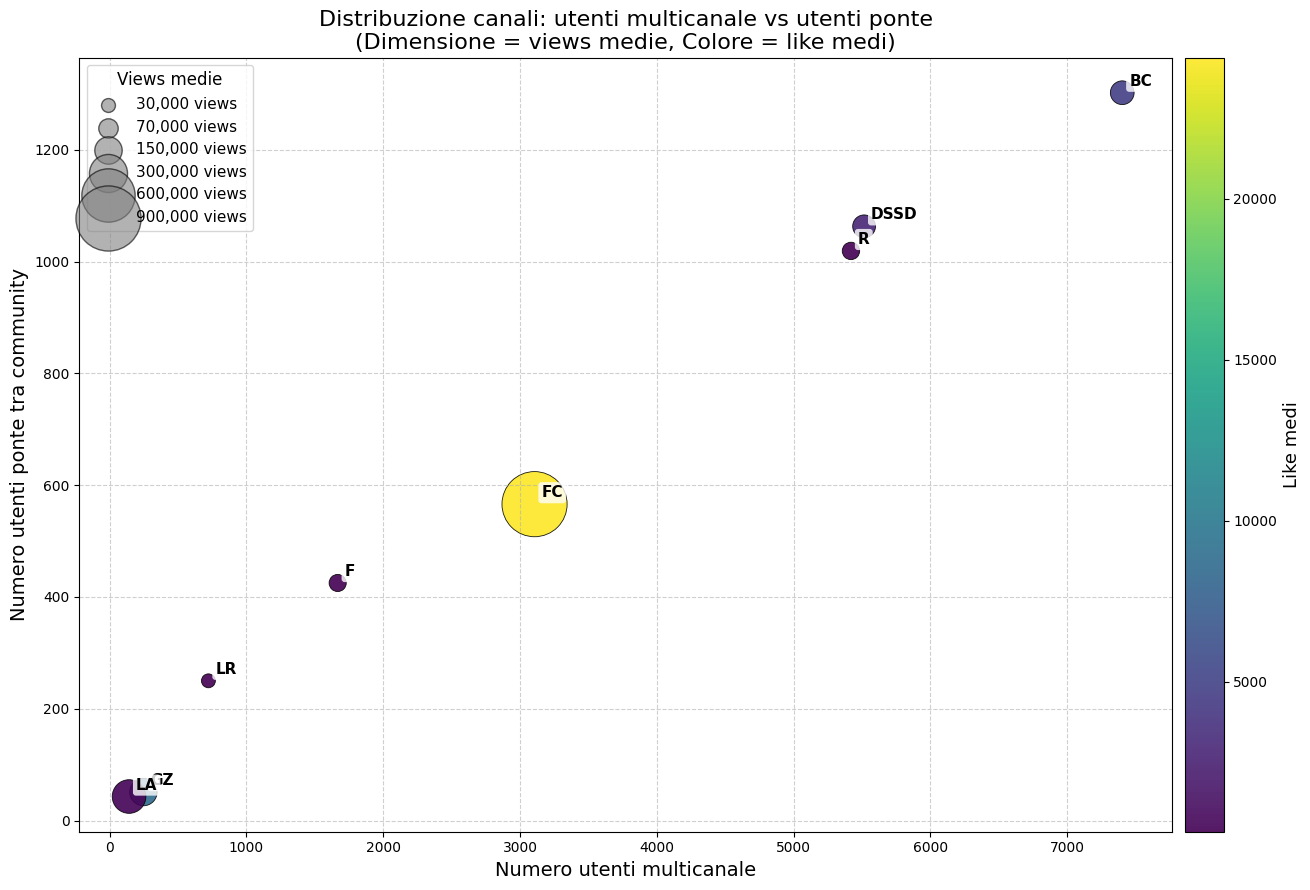

In [20]:
def normalize_sizes(values, min_size=100, max_size=2200):
    v = np.array(values)
    if v.max() == v.min():
        return np.full_like(v, (min_size + max_size) / 2)
    return min_size + (v - v.min()) / (v.max() - v.min()) * (max_size - min_size)

def abbrevia_nome(nome):
    return ''.join([w[0].upper() for w in nome.split() if w[0].isalnum()])

sizes = normalize_sizes(df_confronto["Views_media"])
colors = df_confronto["Likes_media"]
cmap = plt.cm.viridis

fig, ax = plt.subplots(figsize=(14, 9))
sc = ax.scatter(
    df_confronto["Utenti multicanale"],
    df_confronto["Utenti ponte tra community"],
    s=sizes,
    c=colors,
    cmap=cmap,
    alpha=0.9,
    edgecolor="black",
    linewidth=0.6
)

for i, row in df_confronto.iterrows():
    abbreviazione = abbrevia_nome(i)
    ax.annotate(
        abbreviazione,
        (row["Utenti multicanale"], row["Utenti ponte tra community"]),
        textcoords="offset points",
        xytext=(5, 5),
        ha='left',
        fontsize=11,
        weight='bold',
        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.8, lw=0)
    )

ax.set_xlabel("Numero utenti multicanale", fontsize=14)
ax.set_ylabel("Numero utenti ponte tra community", fontsize=14)
ax.set_title(
    "Distribuzione canali: utenti multicanale vs utenti ponte\n(Dimensione = views medie, Colore = like medi)",
    fontsize=16
)

ax.grid(True, linestyle='--', alpha=0.6)
cbar = plt.colorbar(sc, ax=ax, pad=0.01)
cbar.set_label("Like medi", fontsize=13)

legend_views = [30000, 70000, 150000, 300000, 600000, 900000]
legend_s = normalize_sizes(np.array(legend_views))
legend_labels = [f"{v:,} views" for v in legend_views]
legend_handles = [
    plt.scatter([], [], s=s, color='gray', alpha=0.6, edgecolor='black', label=l)
    for s, l in zip(legend_s, legend_labels)
]
ax.legend(
    handles=legend_handles,
    title='Views medie',
    loc='upper left',
    fontsize=11,
    title_fontsize=12,
    frameon=True
)

plt.tight_layout()
plt.show()

In [21]:
# Grafo Video–Video
all_videos = list(Channel_of.keys())

video_video_G = nx.Graph()

for v1, v2 in combinations(all_videos, 2):
    commenters1 = set(Commenters_of_video[v1])
    commenters2 = set(Commenters_of_video[v2])
    common_commenters = commenters1.intersection(commenters2)
    
    if len(common_commenters) > 0:
        video_video_G.add_edge(v1, v2, weight=len(common_commenters))

for video in video_video_G.nodes:
    video_video_G.nodes[video]["channel"] = Channel_of.get(video, "Unknown")
    video_video_G.nodes[video]["date"] = Date_of_video.get(video, "Unknown")

In [22]:
nx.write_gexf(video_video_G, "rete_video_video.gexf")

In [23]:
for n in video_video_G.nodes:
    video_video_G.nodes[n]['viewCount'] = Video_to_views.get(n, 0)
    video_video_G.nodes[n]['likeCount'] = Video_to_likes.get(n, 0)
    print(f"Video {n} - Views: {video_video_G.nodes[n]['viewCount']}, Likes: {video_video_G.nodes[n]['likeCount']}")

Video Ccf0jkSqBpk - Views: 96598, Likes: 198
Video 9sh52chcvu0 - Views: 17905, Likes: 148
Video tFDL9Mx16jc - Views: 21047, Likes: 186
Video xrnTgGRJHz0 - Views: 83548, Likes: 157
Video 0E2znss1aPI - Views: 57815, Likes: 392
Video oaS-KJ0mz20 - Views: 34016, Likes: 314
Video hMD5rLYDUrk - Views: 24645, Likes: 330
Video 9jNySIytgp4 - Views: 29913, Likes: 166
Video -tIRGBdPabA - Views: 83852, Likes: 289
Video MkJULnHa9Ug - Views: 63066, Likes: 805
Video rGQlVoynlWo - Views: 133152, Likes: 839
Video jcym9wXec3c - Views: 24546, Likes: 154
Video ibyXAAz-7eg - Views: 20943, Likes: 226
Video s-HdzEdrcQQ - Views: 55899, Likes: 272
Video PK-Q-YpAASU - Views: 40599, Likes: 321
Video HoJIDggfkDU - Views: 39198, Likes: 477
Video PXOOzIBVgKo - Views: 33125, Likes: 130
Video QyZRLDgKGpM - Views: 24947, Likes: 174
Video fqALwc2qNKE - Views: 11041, Likes: 42
Video Uon0UXL9YtI - Views: 241914, Likes: 946
Video 3KLuu0X2wu8 - Views: 211905, Likes: 2077
Video Vr-ijcH1WUc - Views: 34331, Likes: 147
Video 0

In [24]:
# Calcolo delle statistiche per il grafo video-video
num_nodi = video_video_G.number_of_nodes()
num_archi = video_video_G.number_of_edges()
print(f"\n=== Statistiche Generiche ===")
print(f"Numero di nodi: {num_nodi}")
print(f"Numero di archi: {num_archi}")

densita = nx.density(video_video_G)
print(f"Densità del grafo: {densita:.4f}")

gradi = [d for n, d in video_video_G.degree()]
print(f"Grado medio: {np.mean(gradi):.2f}")
print(f"Grado mediano: {np.median(gradi)}")
print(f"Grado minimo: {np.min(gradi)}")
print(f"Grado massimo: {np.max(gradi)}")


=== Statistiche Generiche ===
Numero di nodi: 351
Numero di archi: 51824
Densità del grafo: 0.8437
Grado medio: 295.29
Grado mediano: 315.0
Grado minimo: 5
Grado massimo: 348



=== Correlazione Jaccard vs Differenza Temporale ===
ρ = -0.1975, p-value = 0.000000
Media diff giorni: 37.52, max: 124

=== Statistiche Similarità Jaccard ===
Media: 0.0190
Mediana: 0.0136
Deviazione standard: 0.0188
Min: 0.0002
Max: 0.1922

=== Statistiche Differenza Temporale (giorni) ===
Media: 37.52
Mediana: 31.00
Deviazione standard: 28.57
Min: 0
Max: 124


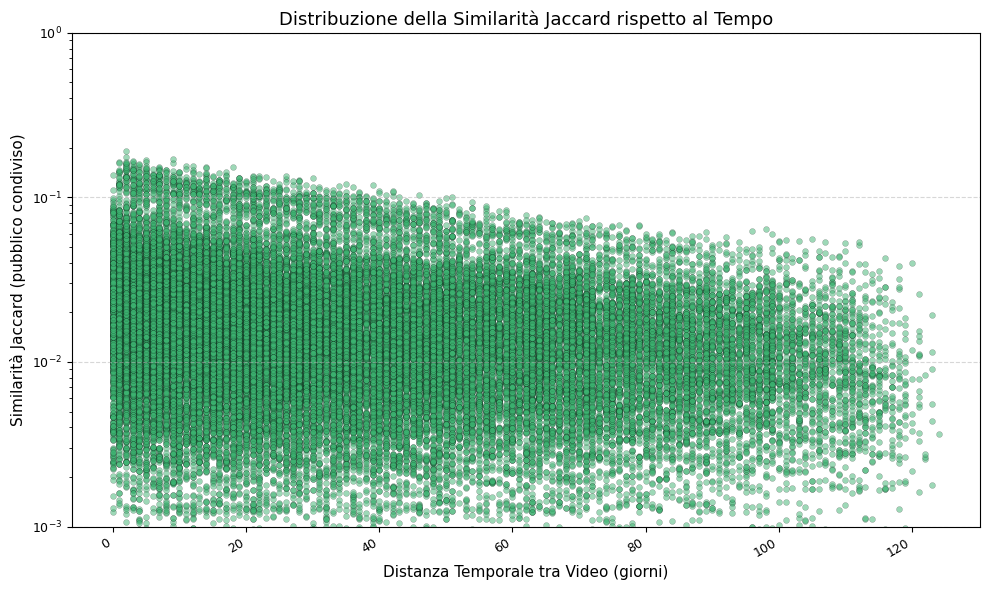

In [25]:
# Calcolo della correlazione tra similarità Jaccard e differenza temporale
jaccard_similarities = []
time_differences = []
view_diffs = []

for node1, node2, data in video_video_G.edges(data=True):
    commenters1 = Commenters_of_video.get(node1, set())
    commenters2 = Commenters_of_video.get(node2, set())

    intersection = len(commenters1.intersection(commenters2))
    union = len(commenters1.union(commenters2))
    jaccard = intersection / union if union > 0 else 0

    date1 = datetime.fromisoformat(Date_of_video.get(node1, "2025-01-01"))
    date2 = datetime.fromisoformat(Date_of_video.get(node2, "2025-01-01"))
    diff_days = abs((date1 - date2).days)

    views1 = Video_to_views.get(node1, 0)
    views2 = Video_to_views.get(node2, 0)
    view_diff = abs(views1 - views2)

    jaccard_similarities.append(jaccard)
    time_differences.append(diff_days)
    view_diffs.append(view_diff)

# Correlazione Spearman
correlation, p_value = spearmanr(jaccard_similarities, time_differences)

print(f"\n=== Correlazione Jaccard vs Differenza Temporale ===")
print(f"ρ = {correlation:.4f}, p-value = {p_value:.6f}")
print(f"Media diff giorni: {np.mean(time_differences):.2f}, max: {np.max(time_differences)}")

print(f"\n=== Statistiche Similarità Jaccard ===")
print(f"Media: {np.mean(jaccard_similarities):.4f}")
print(f"Mediana: {np.median(jaccard_similarities):.4f}")
print(f"Deviazione standard: {np.std(jaccard_similarities):.4f}")
print(f"Min: {np.min(jaccard_similarities):.4f}")
print(f"Max: {np.max(jaccard_similarities):.4f}")

print(f"\n=== Statistiche Differenza Temporale (giorni) ===")
print(f"Media: {np.mean(time_differences):.2f}")
print(f"Mediana: {np.median(time_differences):.2f}")
print(f"Deviazione standard: {np.std(time_differences):.2f}")
print(f"Min: {np.min(time_differences)}")
print(f"Max: {np.max(time_differences)}")

plt.figure(figsize=(10, 6))
plt.scatter(time_differences, jaccard_similarities, alpha=0.5, s=18, color='mediumseagreen', edgecolor='black', linewidth=0.2)
plt.xlabel("Distanza Temporale tra Video (giorni)", fontsize=11)
plt.ylabel("Similarità Jaccard (pubblico condiviso)", fontsize=11)
plt.title("Distribuzione della Similarità Jaccard rispetto al Tempo", fontsize=13)
plt.yscale('log')
plt.ylim(1e-3, 1)
plt.xticks(rotation=30, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

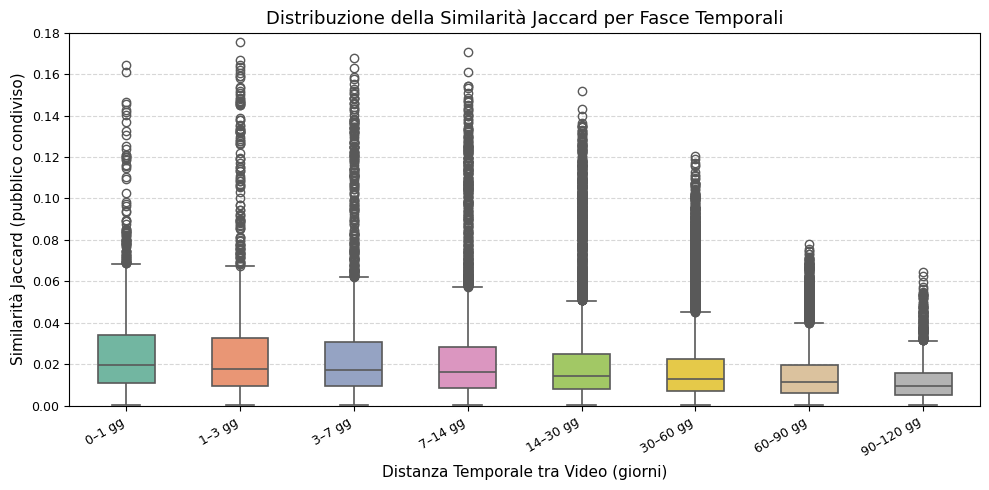


=== Statistiche per Bin Temporale ===
               mean    median       std       min       max  count
Tempo_Bin                                                         
0–1 gg     0.025794  0.019576  0.022232  0.000186  0.164457   1695
1–3 gg     0.026318  0.017857  0.027253  0.000426  0.192207   1903
3–7 gg     0.024277  0.017241  0.023899  0.000185  0.167679   3880
7–14 gg    0.022535  0.016393  0.022171  0.000371  0.170504   6145
14–30 gg   0.020093  0.014286  0.019842  0.000185  0.152136  12028
30–60 gg   0.017511  0.012698  0.016284  0.000370  0.120678  14593
60–90 gg   0.014737  0.011527  0.011999  0.000185  0.077946   8465
90–120 gg  0.011832  0.009259  0.009312  0.000439  0.064336   3085


In [26]:
# Quanto influisce la distanza temporale tra due video sulla similarità del pubblico che li commenta?
df_inverse = pd.DataFrame({
    'Similarità Jaccard': jaccard_similarities,
    'Differenza Temporale (giorni)': time_differences
})

time_bins = [0, 1, 3, 7, 14, 30, 60, 90, 120]
time_labels = [f"{time_bins[i]}–{time_bins[i+1]} gg" for i in range(len(time_bins)-1)]

df_inverse['Tempo_Bin'] = pd.cut(df_inverse['Differenza Temporale (giorni)'], bins=time_bins, labels=time_labels, include_lowest=True)
df_inverse.dropna(subset=['Tempo_Bin'], inplace=True)
df_inverse['Tempo_Bin'] = pd.Categorical(df_inverse['Tempo_Bin'], categories=time_labels, ordered=True)

plt.figure(figsize=(10, 5))  
sns.boxplot(
    x='Tempo_Bin',
    y='Similarità Jaccard',
    hue='Tempo_Bin',         
    data=df_inverse,
    palette='Set2',          
    showfliers=True,        
    width=0.5,               
    linewidth=1.2,
    legend=False             
)

plt.xlabel('Distanza Temporale tra Video (giorni)', fontsize=11)
plt.ylabel('Similarità Jaccard (pubblico condiviso)', fontsize=11)
plt.title('Distribuzione della Similarità Jaccard per Fasce Temporali', fontsize=13)
plt.xticks(rotation=30, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.ylim(0, 0.18)  
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("\n=== Statistiche per Bin Temporale ===")
stats_by_time = df_inverse.groupby('Tempo_Bin', observed=True)['Similarità Jaccard'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
print(stats_by_time)



=== Statistiche Betweenness Centrality (video-video) ===
Media: 0.002581
Mediana: 0.000712
Deviazione standard: 0.005194
Min: 0.000004
Max: 0.051013


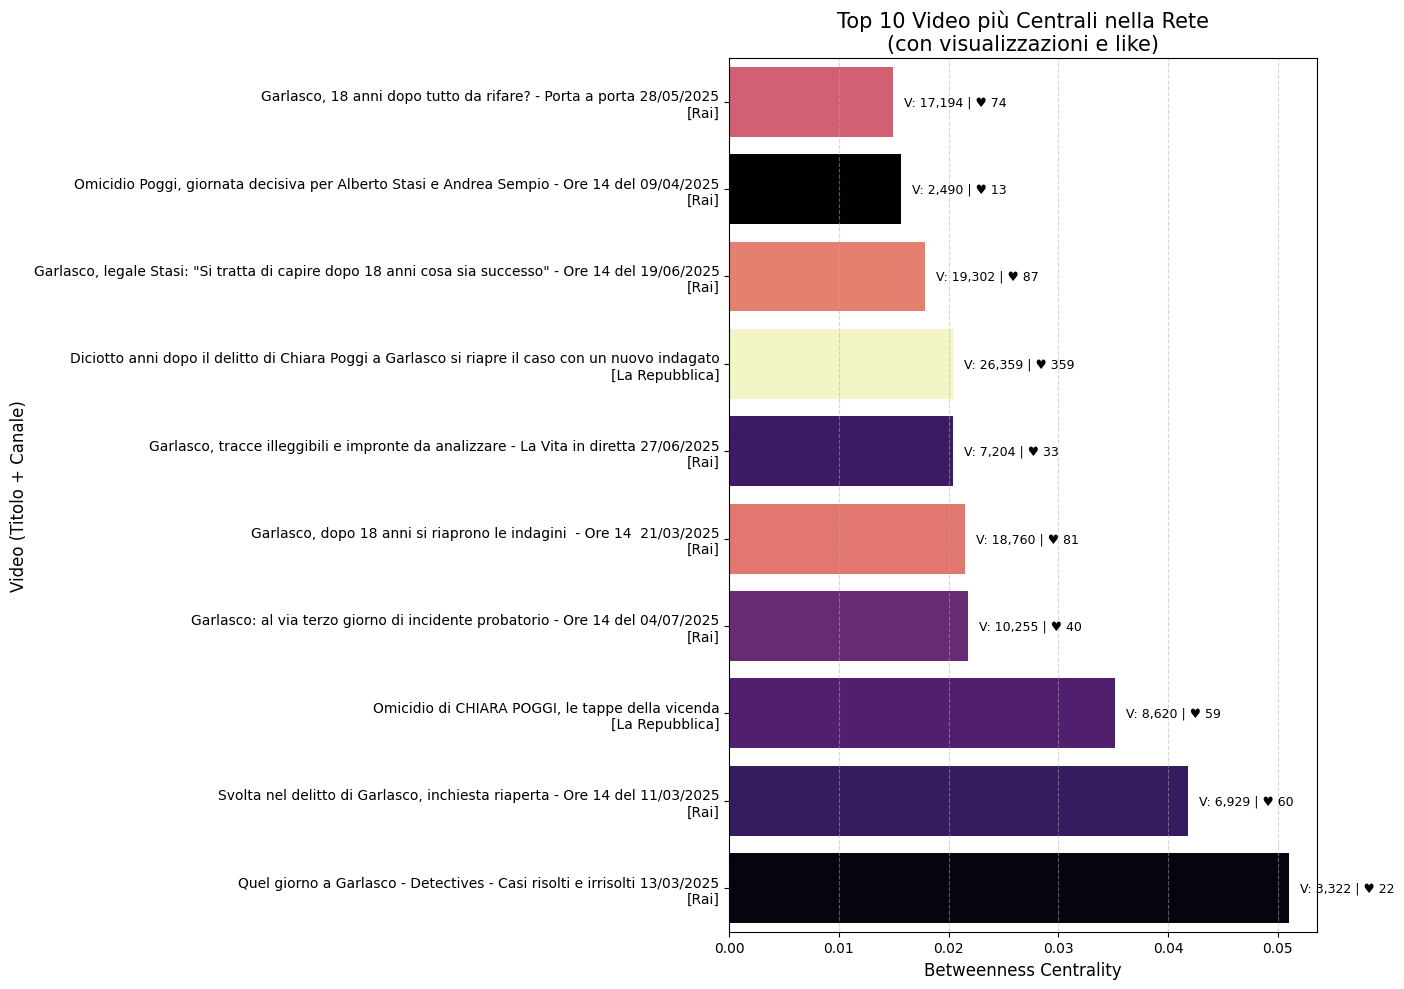

In [37]:
centrality = nx.betweenness_centrality(video_video_G, weight='weight', normalized=True)
nx.set_node_attributes(video_video_G, centrality, 'betweenness')

centrality_values = np.array(list(centrality.values()))
print("\n=== Statistiche Betweenness Centrality (video-video) ===")
print(f"Media: {centrality_values.mean():.6f}")
print(f"Mediana: {np.median(centrality_values):.6f}")
print(f"Deviazione standard: {centrality_values.std():.6f}")
print(f"Min: {centrality_values.min():.6f}")
print(f"Max: {centrality_values.max():.6f}")

TOP_N = 10
top_videos = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:TOP_N]

top_data = []
for vid, centr in top_videos:
    titolo = Video_to_title.get(vid, vid)
    canale = Channel_of.get(vid, "Sconosciuto")
    views = Video_to_views.get(vid, 0)
    likes = Video_to_likes.get(vid, 0)

    top_data.append({
        "video_id": vid,
        "titolo": titolo,
        "canale": canale,
        "centralita": centr,
        "views": views,
        "likes": likes
    })

top_data.reverse()

df_top = pd.DataFrame(top_data)
df_top["etichetta"] = df_top["titolo"] + "\n[" + df_top["canale"] + "]"

norm = plt.Normalize(df_top["views"].min(), df_top["views"].max())
cmap = plt.cm.magma

plt.figure(figsize=(14, 10))
bars = sns.barplot(
    x="centralita",
    y="etichetta",
    hue="etichetta",              
    data=df_top,
    palette=[cmap(norm(v)) for v in df_top["views"]],
    orient='h',
    dodge=False,                  
    legend=False                  
)

for i, row in df_top.iterrows():
    bars.text(
        row["centralita"] + 0.001,
        i,
        f"V: {row['views']:,} | ♥ {row['likes']:,}",
        va='center',
        fontsize=9,
        color='black'
    )

plt.xlabel("Betweenness Centrality", fontsize=12)
plt.ylabel("Video (Titolo + Canale)", fontsize=12)
plt.title(f"Top {TOP_N} Video più Centrali nella Rete\n(con visualizzazioni e like)", fontsize=15)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()